# Time Series RNN

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data is stored in a CSV file, you can load it into a pandas DataFrame
data = pd.read_csv("us.csv", header=None, names=["Date", "Hospitalization", "Death"])

# Convert the "Date" column to a pandas DateTime object
data["Date"] = pd.to_datetime(data["Date"])

# Sort the data by date if it's not already sorted
data.sort_values("Date", inplace=True)

# Extract the values as numpy arrays
Hospitalization = data["Hospitalization"].values.astype(float)
Death = data["Death"].values.astype(float)

# Normalize the data
normalized_Hospitalization = (Hospitalization - np.mean(Hospitalization)) / np.std(Hospitalization)
normalized_Death = (Death - np.mean(Death)) / np.std(Death)

# Define the sequence length and number of features
sequence_length = 100  # Number of previous days to consider
num_features = 2  # Number of input features (Value1 and Value2)

# Create input sequences and corresponding targets
input_sequences = []
targets = []

## all input - sequence length last days
for i in range(len(normalized_Hospitalization) - sequence_length):
    seq = np.array([normalized_Hospitalization[i:i+sequence_length], normalized_Death[i:i+sequence_length]])
    input_sequences.append(seq)
    targets.append([normalized_Hospitalization[i+sequence_length], normalized_Death[i+sequence_length]])

# Convert the input sequences and targets to PyTorch tensors
input_sequences = torch.tensor(input_sequences).float()
targets = torch.tensor(targets).float()

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0[:, :x.size(0), :])
        out = self.fc(out[:, -1, :])
        return out

# Define the hyperparameters
input_size = sequence_length
hidden_size = 64
num_layers = 2
output_size = num_features

# Create an instance of the RNN model
model = RNN(input_size, hidden_size, num_layers, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the input sequences and targets to the device
input_sequences = input_sequences.to(device)
targets = targets.to(device)

# Move the model to the device
model = model.to(device)

# ... previous code ...

# Set the number of training epochs
num_epochs = 10000

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the input sequences and targets to the device
input_sequences = input_sequences.to(device)
targets = targets.to(device)

# Move the model to the device
model = model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    outputs = model(input_sequences)
    loss = criterion(outputs, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")





## Plot Our Model's evaluation

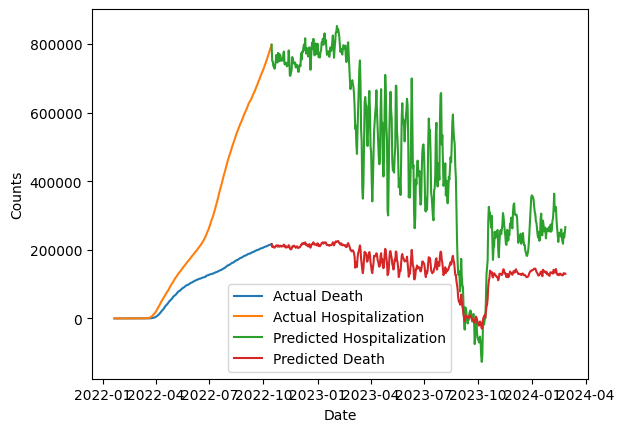

In [6]:
# Switch the model to evaluation mode
model.eval()

# ... previous code ...
daysToPredict = 500

# Generate predictions
with torch.no_grad():
    future_sequence = input_sequences[-1].unsqueeze(0)  # Use the last input sequence as the initial future sequence
    future_sequence = future_sequence.to(device)

    predicted_values = []

    for _ in range(daysToPredict):  
        predictions = model(future_sequence)
        predicted_values.append(predictions.squeeze().tolist())

        # Update the future sequence by removing the first input and appending the new predictions
        new_predictions = torch.tensor([predicted_values[-1]]).unsqueeze(0).to(device)
        future_sequence = torch.cat((future_sequence[:, :, 1:], new_predictions.transpose(1, 2)), dim=2)

# Denormalize the predicted values
predicted_values = np.array(predicted_values)
predicted_values[:, 0] = (predicted_values[:, 0] * np.std(Hospitalization)) + np.mean(Hospitalization)
predicted_values[:, 1] = (predicted_values[:, 1] * np.std(Death)) + np.mean(Death)

# Generate dates for the future predictions
dates = pd.date_range(start=data["Date"].iloc[-1], periods=daysToPredict)

# Plot the actual values and predicted values
plt.plot(data["Date"], data["Death"], label="Actual Death")
plt.plot(data["Date"], (data["Hospitalization"] / 10), label="Actual Hospitalization")
plt.plot(dates, (predicted_values[:, 0] / 10), label="Predicted Hospitalization")
plt.plot(dates, predicted_values[:, 1], label="Predicted Death")
plt.xlabel("Date")
plt.ylabel("Counts")
plt.legend()
plt.show() # 7pm 226


# implementing 
# formalize knowledge idea partial data and built up models on top
# human inspired machine learning computerize idea of 1000 brains. 
# dr tianmen liu pre print. 
# https://www.researchgate.net/publication/369592298_When_Brain-inspired_AI_Meets_AGI
# https://www.numenta.com/resources/research-publications/papers/

# 
# compile lots of features. 
# R not test bed perdiction only RNN. 
# Knowledge embedding
# BTD is for knowledge embedding
# 


## Connecting to Neo4j via py2neo

In [ ]:
from py2neo import Graph
import re

from neo4j import GraphDatabase
from datetime import datetime
# Connect to the Neo4j database
# Remember to change password to your own when running the program. 
graph = Graph("bolt://localhost:7687", user="neo4j", password="Texaco10?123")

# Define the Cypher query to retrieve all data
# county
query = """
MATCH (country:Country)-[:HAS_VARIANT]->(variant:Variant)
OPTIONAL MATCH (variant)-[:HAS_FACTOR]->(factor:Factor)
RETURN country.name AS country, variant.name AS variant, factor.name AS factor, factor.value AS value
"""

result = graph.run(query)

# Create empty lists to store the parsed data
countries = []
variants = []


# Parse the data from the query result
for record in result:
    countries.append(record["country"])
    variants.append(record["variant"])

    factor = record["factor"]
    value = record["value"]

    if factor == "Mortality":
        mortality = value
    elif factor == "Infectiousness":
        infectiousness = value

# Define the Cypher query to retrieve the date value
query = """
MATCH (variant:Variant {name: 'Omicron'})
RETURN date(variant.date) AS date
"""

# Execute the Cypher query and retrieve the date value
result = graph.run(query)
date_value = str(result)



# Extract the date string within the parentheses
date_string = date_value[date_value.find("(") + 1 : date_value.find(")")]
date_string = pd.to_datetime(date_string)

# Parse the date string

print(date_string)
#relation1 = [row['relationship'] for row in results]
#tail1 = [row['english_word'] for row in results]
print(mortality)
print(infectiousness)


## Concat Data RNN

In [4]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data is stored in a CSV file, you can load it into a pandas DataFrame
data = pd.read_csv("UsCovidData.csv", header=None, names=["Date", "RetailRecreation", "GroceryPharmacy", "Parks", "Transit", "Workplace", "Residential", "Hospitalization", "Death" ])

# Convert the "Date" column to a pandas DateTime object
data["Date"] = pd.to_datetime(data["Date"])

# Sort the data by date if it's not already sorted
data.sort_values("Date", inplace=True)

# Extract the values as numpy arrays
Hospitalization = data["Hospitalization"].values.astype(float)
Death = data["Death"].values.astype(float)
RetailRecreation = data["RetailRecreation"].values.astype(float)
GroceryPharmacy = data["GroceryPharmacy"].values.astype(float)
Parks = data["Parks"].values.astype(float)
Transit = data["Transit"].values.astype(float)
Workplace = data["Workplace"].values.astype(float)
Residential = data["Residential"].values.astype(float)

# Normalize the data
normalized_Hospitalization = (Hospitalization - np.mean(Hospitalization)) / np.std(Hospitalization)
normalized_Death = (Death - np.mean(Death)) / np.std(Death)
normalized_RetailRecreation = (RetailRecreation - np.mean(RetailRecreation)) / np.std(RetailRecreation)
normalized_GroceryPharmacy = (GroceryPharmacy - np.mean(GroceryPharmacy)) / np.std(GroceryPharmacy)
normalized_Parks = (Parks - np.mean(Parks)) / np.std(Parks)
normalized_Transit = (Transit - np.mean(Transit)) / np.std(Transit)
normalized_Workplace = (Workplace - np.mean(Workplace)) / np.std(Workplace)
normalize_Residential = (Residential - np.mean(Residential)) / np.std(Residential)


# Define the sequence length and number of features
sequence_length = 10  # Number of previous days to consider
num_features = 8  # Number of input features (Value1 and Value2)

# Create input sequences and corresponding targets
input_sequences = []
targets = []

## all input - sequence length last days
for i in range(len(normalized_Hospitalization) - sequence_length):
    seq = np.array([normalized_Hospitalization[i:i+sequence_length], normalized_Death[i:i+sequence_length],
                    normalized_RetailRecreation[i:i+sequence_length], normalized_GroceryPharmacy[i:i+sequence_length], 
                    normalized_Parks[i:i+sequence_length], normalized_Transit[i:i+sequence_length], 
                    normalized_Workplace[i:i+sequence_length], normalize_Residential[i:i+sequence_length]   ])
    input_sequences.append(seq)
    targets.append([normalized_Hospitalization[i+sequence_length], normalized_Death[i+sequence_length], 
                    normalized_RetailRecreation[i+sequence_length], normalized_GroceryPharmacy[i+sequence_length], 
                    normalized_Parks[i+sequence_length], normalized_Transit[i+sequence_length], 
                    normalized_Workplace[i+sequence_length], normalize_Residential[i+sequence_length]  ])

# Convert the input sequences and targets to PyTorch tensors
input_sequences = torch.tensor(input_sequences).float()

#targets = torch.tensor(np.concatenate(targets)).float()
targets = torch.tensor(targets).float()

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0[:, :x.size(0), :])
        out = self.fc(out[:, -1, :])
        return out

# Define the hyperparameters
input_size = sequence_length
hidden_size = 64
num_layers = 2
output_size = num_features

# Create an instance of the RNN model
model = RNN(input_size, hidden_size, num_layers, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the input sequences and targets to the device
input_sequences = input_sequences.to(device)
targets = targets.to(device)

# Move the model to the device
model = model.to(device)

# ... previous code ...

# Set the number of training epochs
num_epochs = 10000

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the input sequences and targets to the device
input_sequences = input_sequences.to(device)
targets = targets.to(device)

# Move the model to the device
model = model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()
    outputs = model(input_sequences)
    loss = criterion(outputs, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")





Epoch 100/10000, Loss: 0.1740264892578125
Epoch 200/10000, Loss: 0.0653722807765007
Epoch 300/10000, Loss: 0.025864286348223686
Epoch 400/10000, Loss: 0.013488597236573696
Epoch 500/10000, Loss: 0.00869913212954998
Epoch 600/10000, Loss: 0.005976565647870302
Epoch 700/10000, Loss: 0.004213598556816578
Epoch 800/10000, Loss: 0.0030529825016856194
Epoch 900/10000, Loss: 0.00232659000903368
Epoch 1000/10000, Loss: 0.0018102918984368443
Epoch 1100/10000, Loss: 0.0014391080476343632
Epoch 1200/10000, Loss: 0.0011569778434932232
Epoch 1300/10000, Loss: 0.0010408384259790182
Epoch 1400/10000, Loss: 0.0007875634473748505
Epoch 1500/10000, Loss: 0.0006792820640839636
Epoch 1600/10000, Loss: 0.0005533265648409724
Epoch 1700/10000, Loss: 0.0006101708859205246
Epoch 1800/10000, Loss: 0.0004007304669357836
Epoch 1900/10000, Loss: 0.00037340170820243657
Epoch 2000/10000, Loss: 0.00029444575193338096
Epoch 2100/10000, Loss: 0.0002544028975535184
Epoch 2200/10000, Loss: 0.0002316935861017555
Epoch 230